## NBA Career Prediction Experiment

In [3]:
experiment_label = 'logreg03f'

### Aim:
* To combine cross-val and removal of some features, and balanced class.

* To improve on the best so far:

** logreg03b: validation AUC 0.71, precision & recall 91% and 63%, 
and on training set it was 0.71, 90 and 64.

** logreg01: training 0.70, 90, 64, val 0.71, 91, 62 - which is the best Kaggle result (0.71007) despite lower val results.


### Findings:

* Results on training set are AUC 0.70, precision & recall 90 and 64.
* Kaggle score = 0.71032
* A tiny improvement in Kaggle. This is now the best of my models (but Tin's had a better result with a polynomial).


## Load the libraries

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Custom Libraries
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.common_lib import DataReader, NBARawData


# Accuracy Measures
from sklearn.metrics import plot_roc_curve
from src.models.aj_metrics import confusion_matrix


from sklearn import metrics
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Raw Data

In [6]:
# Instantiate the custom data reader class
data_reader = DataReader()

# Load Raw Train Data
train_raw = data_reader.read_data(NBARawData.TRAIN)

# Load Test Raw Data
test_raw = data_reader.read_data(NBARawData.TEST)


### EDA - Correlation Analysis

<AxesSubplot:>

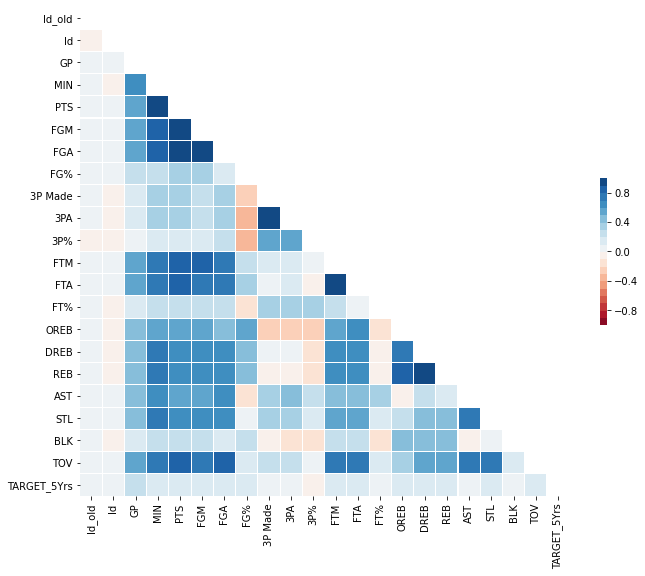

In [34]:
#correlation of potential features
corr = train_raw.corr('pearson')

#hide the top triangle, set fig and axes, choose colours
mask = np.triu(np.ones_like(corr, dtype=bool))   
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("RdBu", 20)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, linewidths=.05, cbar_kws={"shrink": .3})

## Data Preparation - Feature Selection and Scaling

In [53]:
train = train_raw.copy()
test = test_raw.copy()

# Filtering Out the Correlated Features
cols_drop = ['Id_old', 'Id', 'MIN', 'FGM', 'FGA', 'TOV', '3PA', 'FTM', 'FTA', 'REB']
train.drop(cols_drop, axis=1, inplace=True)
test.drop(cols_drop, axis=1, inplace=True)

# Removing the Target Variable before scaling
train_target = train.pop('TARGET_5Yrs')

# Scale The Features in Train and Test sets
train_scaled = data_reader.scale_features_by_standard_scaler(train)
test = data_reader.scale_features_by_standard_scaler(train)

# Save the scaled object
dump(scaler, '../models/aj_' + experiment_label + '_scaler.joblib')

X_train, y_train = train_scaled, train_target

# Modelling - Logistics Regression with Cross Validation

In [54]:
#instantiate the LR model
model = LogisticRegressionCV(class_weight='balanced',max_iter=300,cv=5)

#fit model to training data
model.fit(X_train, y_train)

#save model to file
dump(model,  '../models/aj_' + experiment_label + '.joblib')

['../models/aj_logreg03f.joblib']

### Predict the model on Train set

,pred:0,pred:1
true:0,884,447
true:1,2434,4235


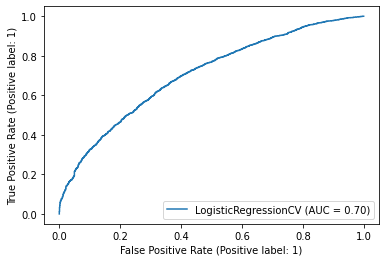

In [55]:
y_train_preds = model.predict(X_train)

plot_roc_curve(model, X_train, y_train)
confusion_matrix(y_train, y_train_preds)

In [56]:
print(metrics.classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

           0       0.27      0.66      0.38      1331
           1       0.90      0.64      0.75      6669

    accuracy                           0.64      8000
   macro avg       0.59      0.65      0.56      8000
weighted avg       0.80      0.64      0.69      8000



### Make Prediction on Test set

In [57]:
y_test_preds = model.predict(test)
y_test_probs = model.predict_proba(test)

submission = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p[1] for p in y_test_probs]})
submission.to_csv('../reports/aj_' + experiment_label + 'submission.csv',index=False)
submission.head()

ValueError: arrays must all be same length